### Homework #2 Course Open Source Energy System Modeling
### *IPCC SR15 scenario assessment*

<img style="float: right; height: 80px; padding-left: 20px;" src="../_static/IIASA_logo.png">
<img style="float: right; height: 80px;" src="../_static/IAMC_logo.jpg">

# Analysis of carbon capture and sequestration (CCS)

This notebook computes indicators and diagnostics of the deployment of CCS by fuel
and the total amount of CO2 stored as shown in **Figure 2.17**
in the IPCC's _"Special Report on Global Warming of 1.5°C"_ and further analyses.

The scenario data used in this analysis can be accessed and downloaded at [https://data.ene.iiasa.ac.at/iamc-1.5c-explorer](https://data.ene.iiasa.ac.at/iamc-1.5c-explorer).

## Load `pyam` package and other dependencies

In [42]:
import pandas as pd
import numpy as np
import io
import itertools
import yaml
import math
import matplotlib.pyplot as plt
%matplotlib inline
import pyam

from utils import boxplot_by_cat

## Import scenario data, categorization and specifications files

The metadata file with scenario categorisation and quantitative indicators can be downloaded at [https://data.ene.iiasa.ac.at/iamc-1.5c-explorer](https://data.ene.iiasa.ac.at/iamc-1.5c-explorer).  
Alternatively, it can be re-created using the notebook `sr15_2.0_categories_indicators`.

The last cell of this section loads and assigns a number of auxiliary lists as defined in the categorization notebook.

In [44]:
sr1p5 = pyam.IamDataFrame(data='../data/iamc15_scenario_data_world_r2.0.xlsx')

pyam.utils - INFO: Reading `../data/iamc15_scenario_data_world_r2.0.xlsx`


In [45]:
sr1p5.load_meta('sr15_metadata_indicators_r2.0.xlsx')

pyam.core - INFO: Importing metadata for 416 scenarios (for total of 416)


In [46]:
with open("sr15_specs.yaml", 'r') as stream:
    specs = yaml.load(stream, Loader=yaml.FullLoader)

rc = pyam.run_control()
for item in specs.pop('run_control').items():
    rc.update({item[0]: item[1]})
cats = specs.pop('cats')
all_cats = specs.pop('all_cats')
subcats = specs.pop('subcats')
all_subcats = specs.pop('all_subcats')
plotting_args = specs.pop('plotting_args')
marker= specs.pop('marker')

## Downselect scenario ensemble to categories of interest for this assessment

Use all years (as of 2020) to correctly compute the total amount of CO2 stored in each scenario.

In [47]:
years = range(2020, 2101, 5)

In [61]:
cats.remove('Above 2C')

In [62]:
df = sr1p5.filter(category=cats, year=years)

## Set specifications for filter and plotting and initialize a data list

In [63]:
plot_ylabel = '{} with CCS (EJ)'
save_name = 'output/fig2.17{}.{}'
figure_format = 'png'

In [64]:
filter_args = dict(df=sr1p5, category=cats, marker=None, join_meta=True)

In [65]:
def plotting_args(name, panel_label=None, filetype=figure_format):
    return {'categories': cats, 'column': 'category', 'years': range(2020, 2101, 10), 'add_marker': marker,
            'ylabel': plot_ylabel.format(name),
            'save': save_name.format(name if panel_label is None else '{}_{}'.format(panel_label, name), filetype)}

In [66]:
data = []

## Extract CCS timeseries data by fuel

In [68]:
ccs_bio = (
    pyam.filter_by_meta(
        df.filter(variable='Primary Energy|Biomass|Modern|w/ CCS')
        .timeseries(), **filter_args)
)

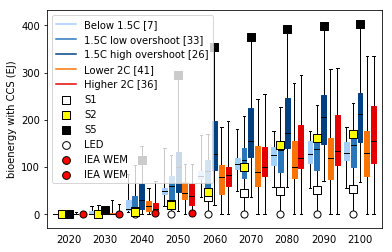

In [69]:
name = 'bioenergy'
fig = boxplot_by_cat(ccs_bio, **plotting_args(name, 'a'))

In [57]:
data.append(('Bioenergy with CCS', ccs_bio))

In [58]:
ccs_coal = (
    pyam.filter_by_meta(
        df.filter(variable='Primary Energy|Coal|w/ CCS')
        .timeseries(), **filter_args)
)

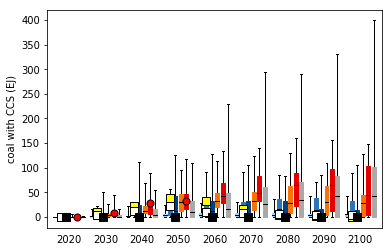

In [59]:
name = 'coal'
boxplot_by_cat(ccs_coal, **plotting_args(name, 'b'), legend=False)

In [60]:
data.append(('Coal with CCS', ccs_coal))

In [ ]:
ccs_gas = (
    pyam.filter_by_meta(
        df.filter(variable='Primary Energy|Gas|w/ CCS')
        .timeseries(), **filter_args)
)

In [ ]:
name = 'gas'
boxplot_by_cat(ccs_gas, **plotting_args(name, 'c'), legend=False)

In [ ]:
data.append(('Gas with CCS', ccs_gas))

## Compute cumulative CO2 stored

In [ ]:
ccs = (
    df.filter(variable='Carbon Sequestration|CCS')
    .convert_unit('Mt CO2/yr', 'Gt CO2/yr')
    .timeseries()
)
ccs.index = ccs.index.droplevel([2, 3, 4])

In [ ]:
cum_ccs = pd.DataFrame()
for i in range(2030, 2100, 10):
    cum_ccs[i] = ccs.apply(pyam.cumulative, raw=False, axis=1, first_year=2020, last_year=i)

cum_ccs = pyam.filter_by_meta(cum_ccs, **filter_args)

In [ ]:
boxplot_by_cat(
    cum_ccs,
    categories=cats, column='category', years=range(2030, 2100, 10),
    ylabel='cumulative CO2 stored (Gt)',
    save=save_name.format('d_cumulative_ccs', figure_format),
    ymax=2050, add_marker=marker, legend=False)

In [ ]:
data.append(('Cumulative CCS', cum_ccs))

## Export timeseries data to `xlsx`

In [ ]:
writer = pd.ExcelWriter('output/fig2.17_data_table.xlsx')
for (name, _df) in data:
    pyam.utils.write_sheet(writer, name, _df, index=True)
writer.save()

In [ ]:
## Analyse CCS for different regions

In [ ]:
sr1p5_regions = pyam.IamDataFrame(data='../data/iamc15_scenario_data_all_regions_r2.0.xlsx')

pyam.utils - INFO: Reading `../data/iamc15_scenario_data_all_regions_r2.0.xlsx`


In [ ]:
## Set specifications for filter and plotting and initialize a data list

In [ ]:
plot_ylabel = '{} with CCS (EJ)'
save_name = 'output/fig_all_regions{}.{}'
figure_format = 'png'

In [ ]:
filter_args = dict(df=sr1p5, category=cats, marker=None, join_meta=True)

In [ ]:
def plotting_args(name, panel_label=None, filetype=figure_format):
    return {'categories': cats, 'column': 'category', 'years': range(2020, 2101, 10), 'add_marker': marker,
            'ylabel': plot_ylabel.format(name),
            'save': save_name.format(name if panel_label is None else '{}_{}'.format(panel_label, name), filetype)